In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
# initialize the set of labels from the spots activity dataset we are
# going to train our network on
LABELS = set(["Burglary", "Normal"])
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images

print("[INFO] loading images...")
imagePaths = list(paths.list_images("Final Dataset"))

data = []
labels = []

# loop over the image paths

for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	
	# if the label of the current image is not part of of the labels
	# are interested in, then ignore the image

	if label not in LABELS:
		continue

	# load the image, convert it to RGB channel ordering, and resize
	# it to be a fixed 224x224 pixels, ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

[INFO] loading images...


In [5]:
def show_image(num):
    image = data[num]
    print("---" * 25)
    print("Shape of the image: ",image.shape)
    print("The label of the image is: ",labels[num])
    print("---" * 25)
    img = plt.imshow(image)
    return plt.show()

---------------------------------------------------------------------------
Shape of the image:  (224, 224, 3)
The label of the image is:  Normal
---------------------------------------------------------------------------


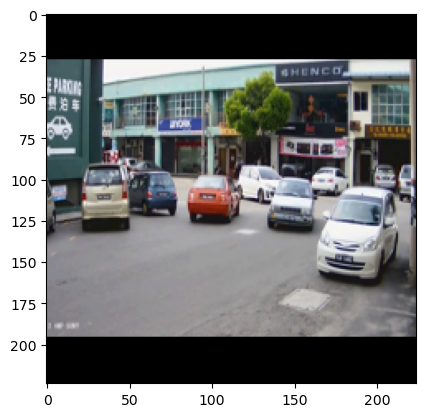

In [6]:
show_image(876)

---------------------------------------------------------------------------
Shape of the image:  (224, 224, 3)
The label of the image is:  Burglary
---------------------------------------------------------------------------


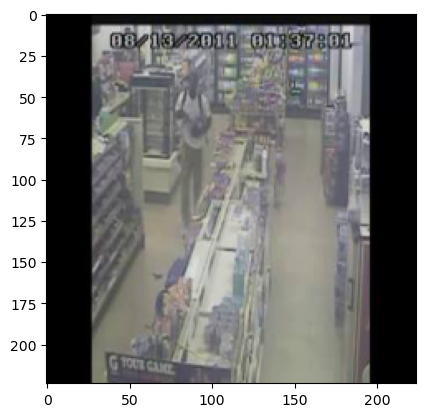

In [7]:
show_image(23)

In [9]:
print("The length of data: ",len(data))
print("The length of labels: ",len(labels))

The length of data:  957
The length of labels:  957


In [10]:
# convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# perform one-hot encoding on the labels
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

In [11]:
#Burglary -> 0
#Normal -> 1

encoder.classes_ 

array(['Burglary', 'Normal'], dtype='<U8')

In [15]:
labels[456:600] #0-476 ->burglary then 477-957 is normal

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.25, shuffle=True ,stratify=labels, random_state=42)

In [19]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)

valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects

mean = np.array([123.68, 116.779, 103.939], dtype="float32")

trainAug.mean = mean
valAug.mean = mean


In [20]:
# load the ResNet-50 network, ensuring the head FC layer sets are left off

baseModel = ResNet50(weights="imagenet", 
		             include_top=False,
	                 input_tensor=Input(shape=(224, 224, 3)))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-06-11 15:11:20.508837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-11 15:11:20.509960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
# construct the head of the model that will be placed on top of the
# the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

In [22]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)

model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

In [24]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer='SGD',metrics=["accuracy"])

[INFO] compiling model...


In [25]:
print("[INFO] training head...")
H = model.fit(
    		x=trainAug.flow(trainX, trainY, batch_size=32),
			steps_per_epoch=len(trainX) // 32,
			validation_data=valAug.flow(testX, testY),
			validation_steps=len(testX) // 32,
			epochs=10,
			verbose=1)


[INFO] training head...
Epoch 1/10


2023-06-11 15:24:16.125139: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-11 15:24:17.533865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.8088

2023-06-11 15:24:28.032345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 15s 516ms/step - loss: 0.5150 - accuracy: 0.8088 - val_loss: 0.2393 - val_accuracy: 0.9509
Epoch 2/10
22/22 [==============================] - 10s 446ms/step - loss: 0.2739 - accuracy: 0.9241 - val_loss: 0.1685 - val_accuracy: 0.9688
Epoch 3/10
22/22 [==============================] - 10s 446ms/step - loss: 0.2243 - accuracy: 0.9416 - val_loss: 0.1279 - val_accuracy: 0.9688
Epoch 4/10
22/22 [==============================] - 10s 462ms/step - loss: 0.1737 - accuracy: 0.9620 - val_loss: 0.0943 - val_accuracy: 0.9955
Epoch 5/10
22/22 [==============================] - 10s 461ms/step - loss: 0.1207 - accuracy: 0.9708 - val_loss: 0.0886 - val_accuracy: 0.9955
Epoch 6/10
22/22 [==============================] - 10s 459ms/step - loss: 0.1062 - accuracy: 0.9766 - val_loss: 0.0692 - val_accuracy: 0.9955
Epoch 7/10
22/22 [==============================] - 10s 450ms/step - loss: 0.1077 - accuracy: 0.9723 - val_loss: 0.0646 - val_accuracy: 1.0000
Epoch 8/10

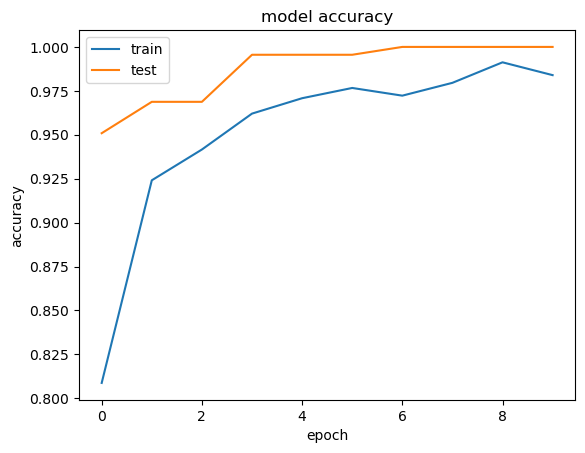

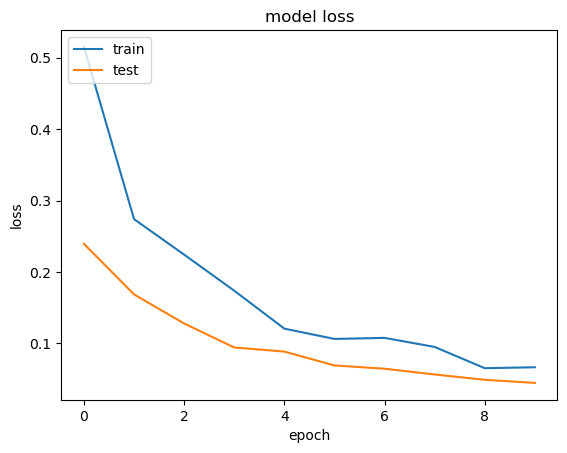

In [26]:
# summarize Model for Accuracy

plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
model.evaluate(x=testX.astype("float32"),y=testY,batch_size=32)

8/8 [==============================] - 3s 375ms/step - loss: 0.0444 - accuracy: 1.0000


[0.04440299794077873, 1.0]

In [28]:
predictions = model.predict(x=testX.astype("float32"), batch_size=32)

2023-06-11 15:29:05.789658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 4s 363ms/step


In [30]:
print("The size of prediction:", len(predictions))

The size of prediction: 240


In [31]:
predictions[:10]

array([[0.13297391],
       [0.01409969],
       [0.01138252],
       [0.00189411],
       [0.02592666],
       [0.09555917],
       [0.9767543 ],
       [0.9963123 ],
       [0.00448543],
       [0.01514835]], dtype=float32)

In [34]:
img = testX[6]

In [40]:
img.shape

(224, 224, 3)

In [41]:
img.ndim

3

In [42]:
img = np.expand_dims(img,axis=0)
img.shape

(1, 224, 224, 3)

In [43]:
p = model.predict(img)

1/1 [==============================] - 0s 130ms/step


In [44]:
p

array([[0.9767543]], dtype=float32)

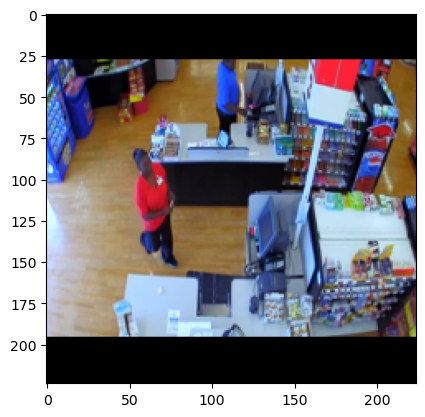

In [46]:
plt.imshow(np.reshape(img,(224,224,3)))
plt.show()

In [62]:
plt.imsave("img.png",np.reshape(img,(224,224,3)))

In [47]:
pred = []
for i in range(len(predictions)):
    if predictions[i]>=0.5:
        pred.append(1) #normal
    else:
        pred.append(0) #burglary

In [48]:
pred[:10]

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0]

In [50]:
from sklearn import metrics

print('Accuracy score is :', metrics.accuracy_score(testY, pred))
print('Precision score is :', metrics.precision_score(testY, pred, average='weighted'))
print('Recall score is :', metrics.recall_score(testY, pred, average='weighted'))
print('F1 Score is :', metrics.f1_score(testY, pred, average='weighted'))

print('\t\tClassification Report:\n', metrics.classification_report(testY, pred))

Accuracy score is : 1.0
Precision score is : 1.0
Recall score is : 1.0
F1 Score is : 1.0
		Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      1.00      1.00       120

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



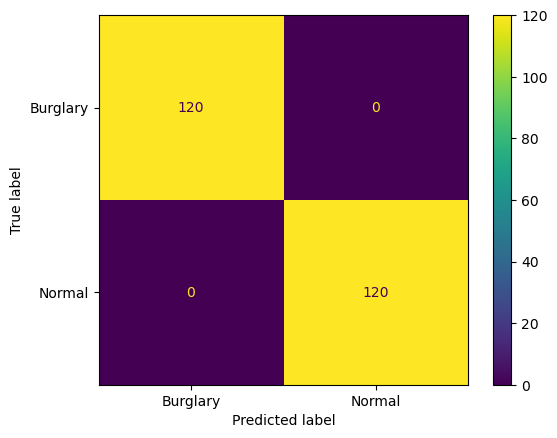

In [52]:
confusion_matrix = metrics.confusion_matrix(testY,pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Burglary', 'Normal'])
cm_display.plot()

In [53]:
import pickle

# serialize the model to disk
print("[INFO] serializing network...")
model.save(filepath='model.h5')

# serialize the label encoder to disk
f = open(file='label_encode',mode='wb')
f.write(pickle.dumps(encoder))
f.close()

[INFO] serializing network...


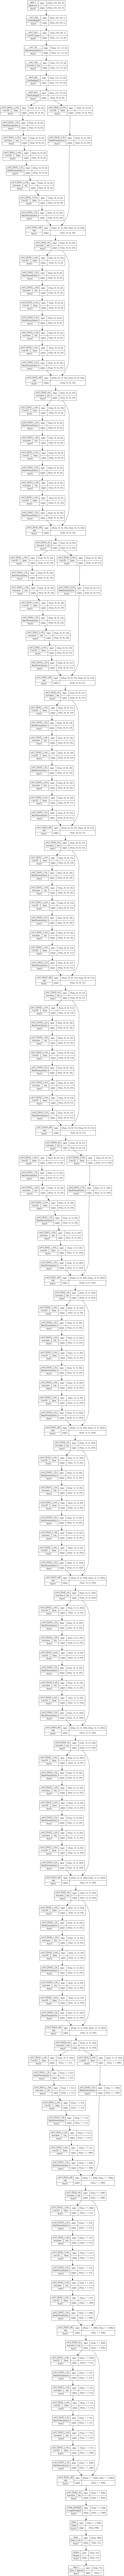

In [57]:
import keras

keras.utils.plot_model(
    model,
    to_file='model_plot.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)